# 统计套利配对选择分析 - 逐步测试框架

本 Notebook 完全复用 `pair_selection_analysis.py` 现有代码，提供方便的逐步测试环境。

## 核心价值
为 `controllers/generic/stat_arb.py` 策略提供**科学的配对选择依据**，通过协整理论和样本外验证确保配对质量。

## 1. 导入现有代码和依赖

直接复用 `pair_selection_analysis.py` 中的所有类和函数。

In [1]:
# 导入现有模块中的所有功能
from pair_selection_analysis import (
    DataLoader, 
    RollingCointegrationAnalyzer,
    analyze_single_pair,
    single_cointegration_analysis,
    batch_cointegration_analysis,
    calculate_half_life
)

import warnings
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ 已导入现有 pair_selection_analysis.py 的所有核心功能")
print("📊 为 stat_arb 策略提供科学配对选择支持")

✅ 已导入现有 pair_selection_analysis.py 的所有核心功能
📊 为 stat_arb 策略提供科学配对选择支持


## 2. 配置数据路径和参数

使用与现有代码一致的默认配置，专为 stat_arb 策略优化。

In [2]:
# 复用现有默认配置 (pair_selection_analysis.py:520-522)
DATA_DIR = '/Users/zhanghao/GitHub/hummingbot/data/futures_5m'
OUTPUT_DIR = '/Users/zhanghao/GitHub/hummingbot/data/analysis/futures_5m'

# 复用现有分析器默认参数 (pair_selection_analysis.py:540-545)
WINDOW_SIZE = 600      # IS/OS 窗口大小，匹配 stat_arb lookback_period
STEP_SIZE = 300        # 滚动步长，支持重叠分析
IS_PVALUE = 0.1        # IS协整阈值，90%置信度
OS_PVALUE = 0.2        # OS验证标准
START_DATE = '2023-01-01'

print(f"📁 数据目录: {DATA_DIR}")
print(f"📊 输出目录: {OUTPUT_DIR}")
print(f"🔧 分析参数: window_size={WINDOW_SIZE}, step_size={STEP_SIZE}")
print(f"📈 协整阈值: IS={IS_PVALUE}, OS={OS_PVALUE}")

📁 数据目录: /Users/zhanghao/GitHub/hummingbot/data/futures_5m
📊 输出目录: /Users/zhanghao/GitHub/hummingbot/data/analysis/futures_5m
🔧 分析参数: window_size=600, step_size=300
📈 协整阈值: IS=0.1, OS=0.2


## 3. 初始化核心组件

复用现有 DataLoader 和 RollingCointegrationAnalyzer 类。

In [3]:
# 使用现有 DataLoader 类 (pair_selection_analysis.py:37-95)
print("🔄 初始化数据加载器...")
data_loader = DataLoader(data_dir=DATA_DIR)

# 使用现有 RollingCointegrationAnalyzer 类 (pair_selection_analysis.py:97-362)
print("🔧 创建协整分析器...")
analyzer = RollingCointegrationAnalyzer(
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE,
    is_pvalue_threshold=IS_PVALUE,
    os_pvalue_threshold=OS_PVALUE
)

# 创建输出目录
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(exist_ok=True, parents=True)

print(f"✅ 组件初始化完成")
print(f"📋 可用币种: {len(data_loader.pairs)} 个")
print(f"🔍 示例币种: {data_loader.pairs[:10]}")

🔄 初始化数据加载器...
Found 52 symbols
🔧 创建协整分析器...
✅ 组件初始化完成
📋 可用币种: 52 个
🔍 示例币种: ['VIDTUSDT', 'ARBUSDT', 'SEIUSDT', 'OGUSDT', 'TIAUSDT', 'DOTUSDT', 'MYXUSDT', 'AIOTUSDT', 'PROVEUSDT', 'DOGEUSDT']


## 4. 数据加载测试

测试 DataLoader 的数据加载功能，确保数据质量。

In [4]:
# 选择测试配对 - 使用高流动性币种
test_coin1, test_coin2 = 'BTC', 'ETH'  # 经典配对

print(f"🧪 测试数据加载: {test_coin1}-{test_coin2}")
print("="*50)

# 使用现有 load_pair_data 方法
test_data = data_loader.load_pair_data(
    coin1=test_coin1, 
    coin2=test_coin2, 
    start_date=START_DATE,
    silent=False
)

if test_data is not None:
    print(f"\n📊 数据质量检查:")
    print(f"- 总记录数: {len(test_data):,}")
    print(f"- 时间跨度: {(test_data['timestamp'].max() - test_data['timestamp'].min()).days} 天")
    print(f"- 缺失值检查: {test_data.isnull().sum().sum()} 个")
    print(f"- 价格范围: {test_coin1} [${test_data[f'{test_coin1}_price'].min():.2f} - ${test_data[f'{test_coin1}_price'].max():.2f}]")
    print(f"- 价格范围: {test_coin2} [${test_data[f'{test_coin2}_price'].min():.2f} - ${test_data[f'{test_coin2}_price'].max():.2f}]")
    
    # 显示数据样本
    print(f"\n📈 数据样本 (最近5行):")
    display(test_data.tail())
    
    # 检查是否满足分析要求
    min_required = 2 * WINDOW_SIZE
    print(f"\n✅ 数据充足性检查:")
    print(f"- 最小需求: {min_required:,} 条记录")
    print(f"- 实际数量: {len(test_data):,} 条记录")
    print(f"- 状态: {'✅ 充足' if len(test_data) >= min_required else '❌ 不足'}")
    
else:
    print("❌ 数据加载失败")

🧪 测试数据加载: BTC-ETH
Loaded 276049 aligned records for BTC-ETH
Time range: 2023-01-01 00:00:00+00:00 to 2025-08-16 12:00:00+00:00

📊 数据质量检查:
- 总记录数: 276,049
- 时间跨度: 958 天
- 缺失值检查: 0 个
- 价格范围: BTC [$100.50 - $124300.00]
- 价格范围: ETH [$1192.00 - $4784.75]

📈 数据样本 (最近5行):


,timestamp,BTC_price,BTC_volume,ETH_price,ETH_volume
276044,2025-08-16 11:40:00+00:00,117365.2,88.519,4398.26,13594.044
276045,2025-08-16 11:45:00+00:00,117417.7,78.318,4402.14,8785.465
276046,2025-08-16 11:50:00+00:00,117312.9,287.399,4384.58,44543.870
276047,2025-08-16 11:55:00+00:00,117340.4,115.531,4385.89,15194.885
276048,2025-08-16 12:00:00+00:00,117388.3,186.728,4391.10,24997.518



✅ 数据充足性检查:
- 最小需求: 1,200 条记录
- 实际数量: 276,049 条记录
- 状态: ✅ 充足


## 5. 单配对协整分析测试

使用现有 `analyze_pair_rolling` 方法进行详细分析。

🔬 开始协整分析: BTC-ETH
📊 分析参数: 600K IS + 600K OS 滚动窗口
Analyzing BTC-ETH with 600K IS + 600K OS windows...

=== BTC-ETH 协整分析摘要 ===
总窗口数: 917
IS协整率: 78.19%
OS协整率: 20.28%
双重协整率: 16.68%
Beta稳定性(CV): 0.646
平均R-squared: 0.666
IS平均半衰期: 71.0 periods
OS平均半衰期: 100.0 periods
半衰期稳定性: 0.408
综合评分: 0.457


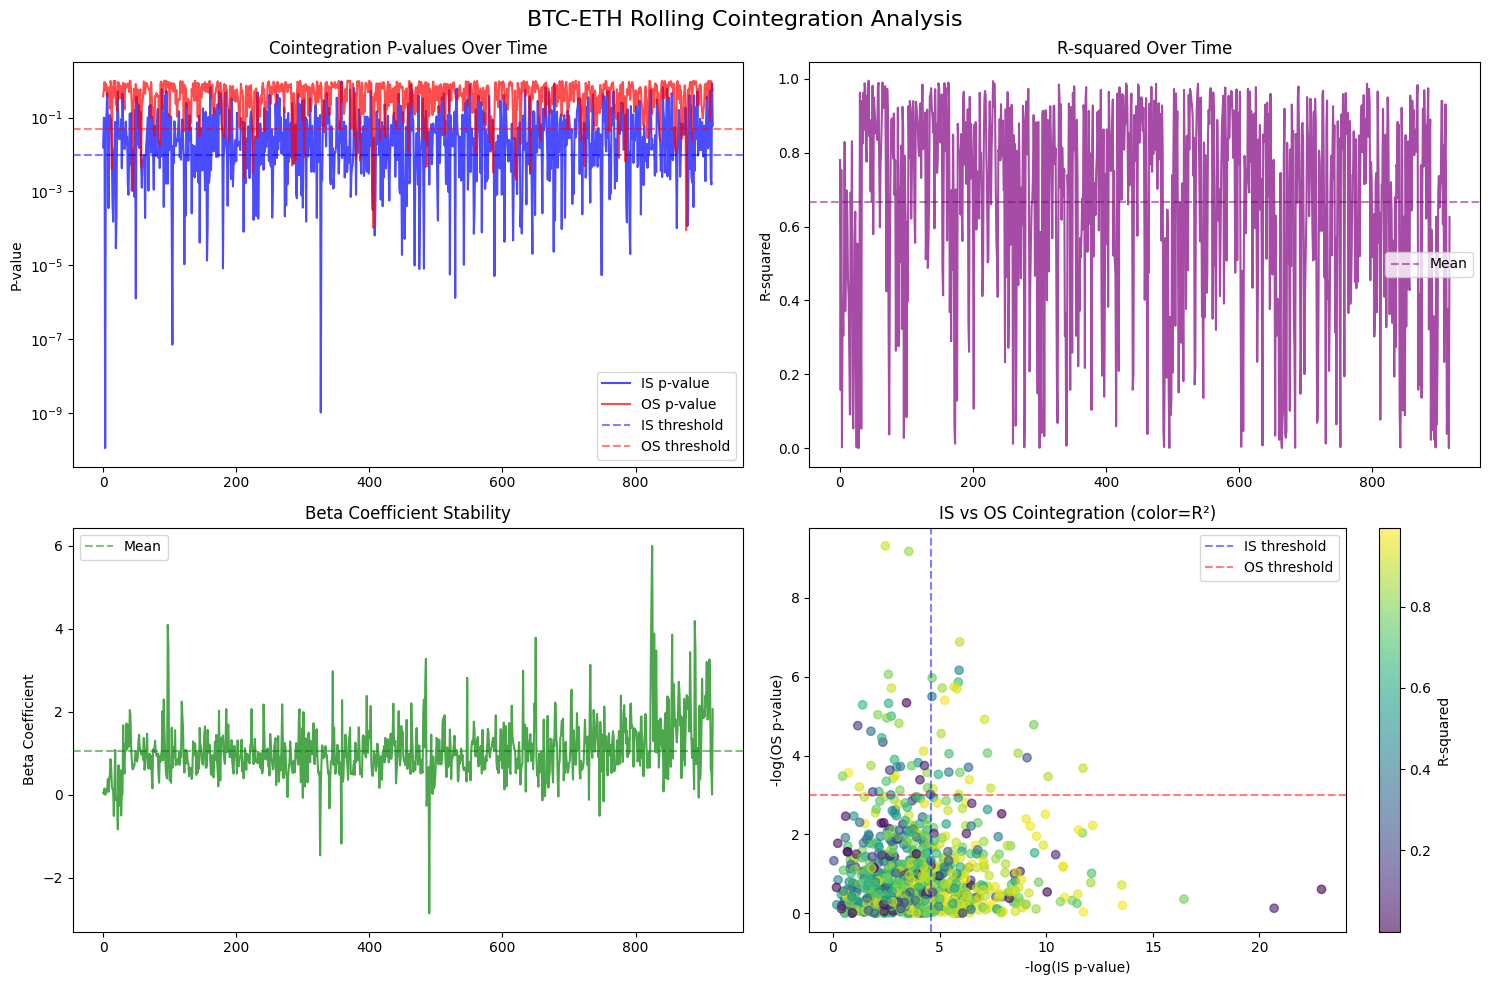


🎯 stat_arb 策略关键指标评估:
📈 配对质量评分: 0.457
🔄 双重协整率: 16.68% ❌ 较差
📊 平均R²: 0.666 ⚠️ 中等
🎚️ Beta稳定性: 0.646 ❌ 不稳定
⏱️ IS平均半衰期: 71.0 periods ✅ 适中

🎯 stat_arb 控制器参数建议:
- connector_pair_dominant: 'BTC-USDT'
- connector_pair_hedge: 'ETH-USDT'
- lookback_period: 426 (基于半衰期×6)

📋 滚动窗口分析结果 (共917个窗口):


,window_start,alpha,beta,r_squared,is_pvalue,os_pvalue,both_cointegrated
0,0,6.842639,0.051644,0.780101,1.562221e-02,0.378649,False
1,300,7.001631,0.019556,0.157005,9.930523e-02,0.596963,False
2,600,6.324256,0.151197,0.753353,8.726666e-02,0.922538,False
3,900,7.139722,-0.001387,0.001956,1.119401e-10,0.543680,False
4,1200,6.815599,0.057753,0.400012,6.805954e-02,0.828675,False
5,1500,6.840975,0.052942,0.304864,1.255400e-01,0.754429,False
6,1800,6.328194,0.142757,0.448317,4.665934e-01,0.451195,False
7,2100,4.973466,0.376993,0.828966,9.566897e-02,0.361865,False
8,2400,6.770202,0.071364,0.371354,3.524286e-04,0.656209,False
9,2700,5.082392,0.354616,0.561750,4.563103e-02,0.484930,False


In [5]:
# 执行单配对协整分析 - 复用现有方法 (pair_selection_analysis.py:107-189)
if test_data is not None and len(test_data) >= 2 * WINDOW_SIZE:
    print(f"🔬 开始协整分析: {test_coin1}-{test_coin2}")
    print(f"📊 分析参数: {WINDOW_SIZE}K IS + {WINDOW_SIZE}K OS 滚动窗口")
    print("="*60)
    
    # 使用现有分析器的核心方法
    result = analyzer.analyze_pair_rolling(
        data=test_data, 
        coin1=test_coin1, 
        coin2=test_coin2, 
        silent=False  # 显示详细输出和图表
    )
    
    if result and result['summary']:
        summary = result['summary']
        results_df = result['results']
        
        print(f"\n🎯 stat_arb 策略关键指标评估:")
        print("="*50)
        print(f"📈 配对质量评分: {summary['overall_score']:.3f}")
        print(f"🔄 双重协整率: {summary['both_cointegration_rate']:.2%} {'✅ 优秀' if summary['both_cointegration_rate'] > 0.5 else '⚠️ 一般' if summary['both_cointegration_rate'] > 0.3 else '❌ 较差'}")
        print(f"📊 平均R²: {summary['avg_r_squared']:.3f} {'✅ 强关联' if summary['avg_r_squared'] > 0.7 else '⚠️ 中等' if summary['avg_r_squared'] > 0.5 else '❌ 弱关联'}")
        print(f"🎚️ Beta稳定性: {summary['beta_cv']:.3f} {'✅ 稳定' if summary['beta_cv'] < 0.1 else '⚠️ 一般' if summary['beta_cv'] < 0.2 else '❌ 不稳定'}")
        
        if summary['avg_is_half_life']:
            half_life = summary['avg_is_half_life']
            print(f"⏱️ IS平均半衰期: {half_life:.1f} periods {'✅ 适中' if 20 <= half_life <= 100 else '⚠️ 需注意'}")
            
            # 为 stat_arb 控制器提供参数建议
            suggested_lookback = max(300, int(half_life * 6))
            print(f"\n🎯 stat_arb 控制器参数建议:")
            print(f"- connector_pair_dominant: '{test_coin1}-USDT'")
            print(f"- connector_pair_hedge: '{test_coin2}-USDT'")
            print(f"- lookback_period: {suggested_lookback} (基于半衰期×6)")
        
        # 显示详细结果数据框
        print(f"\n📋 滚动窗口分析结果 (共{len(results_df)}个窗口):")
        display_cols = ['window_start', 'alpha', 'beta', 'r_squared', 'is_pvalue', 'os_pvalue', 'both_cointegrated']
        display(results_df[display_cols].head(10))
        
    else:
        print("❌ 协整分析失败")
        
else:
    print("⚠️ 跳过协整分析 - 数据不足")

## 6. 参数敏感性测试

测试不同参数设置对分析结果的影响。

In [6]:
# 参数敏感性测试 - 创建多个分析器实例
print("🔬 参数敏感性测试")
print("="*40)

# 定义测试参数组合
param_configs = [
    {'name': '保守策略', 'window_size': 300, 'is_pvalue': 0.01, 'os_pvalue': 0.05, 'desc': '高质量配对'},
    {'name': '标准策略', 'window_size': 600, 'is_pvalue': 0.1, 'os_pvalue': 0.2, 'desc': '平衡配置'},
    {'name': '探索策略', 'window_size': 800, 'is_pvalue': 0.15, 'os_pvalue': 0.25, 'desc': '发现更多候选'}
]

sensitivity_results = []

if test_data is not None:
    for config in param_configs:
        print(f"\n🧪 测试 {config['name']} ({config['desc']})")
        
        # 检查数据充足性
        min_required = 2 * config['window_size']
        if len(test_data) < min_required:
            print(f"⚠️ 跳过 - 需要 {min_required} 条记录，实际 {len(test_data)} 条")
            continue
        
        # 创建专门的分析器
        test_analyzer = RollingCointegrationAnalyzer(
            window_size=config['window_size'],
            step_size=config['window_size'],
            is_pvalue_threshold=config['is_pvalue'],
            os_pvalue_threshold=config['os_pvalue']
        )
        
        # 执行分析（静默模式）
        result = test_analyzer.analyze_pair_rolling(
            data=test_data, 
            coin1=test_coin1, 
            coin2=test_coin2, 
            silent=True
        )
        
        if result and result['summary']:
            summary = result['summary']
            sensitivity_results.append({
                '策略': config['name'],
                '窗口大小': config['window_size'],
                'IS阈值': config['is_pvalue'],
                'OS阈值': config['os_pvalue'],
                '双重协整率': f"{summary['both_cointegration_rate']:.2%}",
                '平均R²': f"{summary['avg_r_squared']:.3f}",
                'Beta稳定性': f"{summary['beta_cv']:.3f}",
                '综合评分': f"{summary['overall_score']:.3f}",
                '分析窗口数': summary['total_windows']
            })
            
            print(f"  📊 双重协整率: {summary['both_cointegration_rate']:.2%}")
            print(f"  🎯 综合评分: {summary['overall_score']:.3f}")
        else:
            print(f"  ❌ 分析失败")

    # 显示参数比较结果
    if sensitivity_results:
        print(f"\n📊 参数敏感性分析结果:")
        sensitivity_df = pd.DataFrame(sensitivity_results)
        display(sensitivity_df)
        
        print(f"\n💡 参数选择建议:")
        print(f"- 保守策略适合风险厌恶型，要求高质量配对")
        print(f"- 标准策略平衡质量和数量，推荐日常使用")
        print(f"- 探索策略发现更多候选，适合初期筛选")
else:
    print("⚠️ 跳过参数测试 - 数据加载失败")

🔬 参数敏感性测试

🧪 测试 保守策略 (高质量配对)
  📊 双重协整率: 2.18%
  🎯 综合评分: 0.250

🧪 测试 标准策略 (平衡配置)
  📊 双重协整率: 17.65%
  🎯 综合评分: 0.458

🧪 测试 探索策略 (发现更多候选)
  📊 双重协整率: 22.97%
  🎯 综合评分: 0.510

📊 参数敏感性分析结果:


,策略,窗口大小,IS阈值,OS阈值,双重协整率,平均R²,Beta稳定性,综合评分,分析窗口数
0,保守策略,300,0.01,0.05,2.18%,0.663,0.628,0.250,919
1,标准策略,600,0.10,0.20,17.65%,0.664,0.674,0.458,459
2,探索策略,800,0.15,0.25,22.97%,0.662,0.592,0.510,344



💡 参数选择建议:
- 保守策略适合风险厌恶型，要求高质量配对
- 标准策略平衡质量和数量，推荐日常使用
- 探索策略发现更多候选，适合初期筛选


## 7. 批量分析预览测试

小规模测试批量分析功能，验证多线程处理。

In [ ]:
# 小规模批量分析测试
print("🔄 批量分析预览测试")
print("="*40)

# 选择少量高流动性币种进行测试
test_coins = ['BTC', 'ETH', 'BNB', 'SOL']  # 4个币种 = 12个配对组合

# 检查数据可用性
available_test_coins = []
for coin in test_coins:
    pair_name = f"{coin}USDT"
    if pair_name in data_loader.pairs:
        available_test_coins.append(coin)
    else:
        print(f"⚠️ {coin} 数据不可用")

print(f"📋 可用测试币种: {available_test_coins}")

if len(available_test_coins) >= 2:
    # 模拟批量分析功能测试
    import itertools
    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm
    
    # 生成所有配对组合
    test_pairs = list(itertools.permutations(available_test_coins, 2))
    print(f"📊 待分析配对: {len(test_pairs)} 个")
    print(f"🔧 使用分析参数: window_size={WINDOW_SIZE}, 阈值=IS:{IS_PVALUE}/OS:{OS_PVALUE}")
    
    # 使用较少线程进行测试
    max_workers = min(4, len(test_pairs))
    print(f"⚙️ 使用线程数: {max_workers}")
    
    # 准备多线程参数
    thread_args = [(data_loader, coin1, coin2, START_DATE, analyzer, i % max_workers) 
                   for i, (coin1, coin2) in enumerate(test_pairs)]
    
    # 执行批量分析
    all_summaries = []
    failed_pairs = []
    
    print(f"\n🚀 开始批量分析...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交所有任务
        future_to_pair = {executor.submit(analyze_single_pair, args): args for args in thread_args}
        
        # 收集结果
        for future in tqdm(as_completed(future_to_pair), total=len(test_pairs), desc="分析进度"):
            try:
                summary, failed = future.result()
                if summary:
                    all_summaries.append(summary)
                if failed:
                    failed_pairs.append(failed)
            except Exception as e:
                args = future_to_pair[future]
                coin1, coin2 = args[1], args[2]
                failed_pairs.append({'pair': f'{coin1}-{coin2}', 'reason': f'error: {str(e)}'})
    
    # 显示结果
    print(f"\n📊 批量分析结果:")
    print(f"✅ 成功分析: {len(all_summaries)} 个配对")
    print(f"❌ 失败分析: {len(failed_pairs)} 个配对")
    
    if all_summaries:
        # 转换为DataFrame并排序
        summaries_df = pd.DataFrame(all_summaries)
        summaries_df = summaries_df.sort_values('overall_score', ascending=False)
        
        print(f"\n🏆 TOP 配对结果 (按综合评分排序):")
        display_cols = ['pair', 'both_cointegration_rate', 'avg_r_squared', 'beta_cv', 'overall_score']
        display(summaries_df[display_cols])
        
        # 统计分析
        high_quality_pairs = summaries_df[summaries_df['both_cointegration_rate'] > 0.5]
        print(f"\n🎯 stat_arb 策略建议:")
        print(f"📈 高质量配对 (双重协整率>50%): {len(high_quality_pairs)} 个")
        
        if len(high_quality_pairs) > 0:
            best_pair = high_quality_pairs.iloc[0]
            pair_name = best_pair['pair']
            coin1, coin2 = pair_name.split('-')
            print(f"🥇 推荐最优配对: {pair_name}")
            print(f"   - 双重协整率: {best_pair['both_cointegration_rate']:.2%}")
            print(f"   - 综合评分: {best_pair['overall_score']:.3f}")
            print(f"\n🔧 控制器配置建议:")
            print(f"   connector_pair_dominant: '{coin1}-USDT'")
            print(f"   connector_pair_hedge: '{coin2}-USDT'")
    
    if failed_pairs:
        print(f"\n⚠️ 失败配对:")
        failed_df = pd.DataFrame(failed_pairs)
        display(failed_df)
        
else:
    print("❌ 无足够测试币种进行批量分析")

## 8. 快速工具函数

提供一些便捷的工具函数用于快速测试和调试。

In [ ]:
# 快速工具函数集合

def quick_pair_check(coin1, coin2, silent=True):
    """
    快速检查单个配对的协整质量
    复用现有 DataLoader 和 RollingCointegrationAnalyzer
    """
    print(f"🔍 快速检查: {coin1}-{coin2}")
    
    # 检查数据可用性
    pair1, pair2 = f"{coin1}USDT", f"{coin2}USDT"
    if pair1 not in data_loader.pairs or pair2 not in data_loader.pairs:
        print(f"❌ 数据不可用")
        return None
    
    # 加载数据
    data = data_loader.load_pair_data(coin1, coin2, start_date=START_DATE, silent=silent)
    if data is None or len(data) < 2 * WINDOW_SIZE:
        print(f"❌ 数据不足")
        return None
    
    # 执行分析
    result = analyzer.analyze_pair_rolling(data, coin1, coin2, silent=silent)
    if result and result['summary']:
        summary = result['summary']
        score = summary['overall_score']
        coint_rate = summary['both_cointegration_rate']
        
        status = "🏆 优秀" if score > 0.6 and coint_rate > 0.5 else "✅ 良好" if score > 0.4 else "⚠️ 一般"
        print(f"{status} - 评分: {score:.3f}, 协整率: {coint_rate:.2%}")
        return summary
    else:
        print(f"❌ 分析失败")
        return None


def list_available_coins(show_count=20):
    """
    显示可用的币种列表
    """
    print(f"📋 可用币种 (共{len(data_loader.pairs)}个):")
    
    # 提取币种名称并排序
    coins = sorted([pair.replace('USDT', '') for pair in data_loader.pairs])
    
    # 分组显示
    for i in range(0, min(len(coins), show_count), 10):
        row_coins = coins[i:i+10]
        print(f"  {' | '.join(row_coins)}")
    
    if len(coins) > show_count:
        print(f"  ... 还有 {len(coins) - show_count} 个币种")
    
    return coins


def suggest_stat_arb_config(pair_name, summary=None):
    """
    根据分析结果生成 stat_arb 控制器配置建议
    """
    if '-' not in pair_name:
        print("❌ 配对格式错误，应为 'COIN1-COIN2'")
        return
    
    coin1, coin2 = pair_name.split('-')
    
    print(f"🔧 {pair_name} stat_arb 配置建议:")
    print(f"connector_pair_dominant: '{coin1}-USDT'")
    print(f"connector_pair_hedge: '{coin2}-USDT'")
    
    if summary and summary.get('avg_is_half_life'):
        half_life = summary['avg_is_half_life']
        suggested_lookback = max(300, int(half_life * 6))
        print(f"lookback_period: {suggested_lookback}  # 基于半衰期 {half_life:.1f} × 6")
    else:
        print(f"lookback_period: 300  # 默认值")
    
    if summary:
        print(f"\n📊 分析依据:")
        print(f"- 双重协整率: {summary['both_cointegration_rate']:.2%}")
        print(f"- 综合评分: {summary['overall_score']:.3f}")
        print(f"- Beta稳定性: {summary['beta_cv']:.3f}")


# 使用示例
print("🛠️ 快速工具函数已定义")
print("""\n📖 使用方法:
1. quick_pair_check('BTC', 'ETH') - 快速检查配对质量
2. list_available_coins() - 查看可用币种
3. suggest_stat_arb_config('BTC-ETH', summary) - 生成配置建议
""")

# 显示可用币种
available_coins = list_available_coins(30)

## 9. 交互式测试区域

用于快速测试和实验的交互式区域。

In [ ]:
# 🧪 交互式测试区域
# 在这里进行各种快速测试和实验

print("🧪 交互式测试区域")
print("="*40)

# 示例1: 快速检查几个热门配对
popular_pairs = [('BTC', 'ETH'), ('BNB', 'SOL'), ('ADA', 'DOT')]

print("\n🔥 热门配对快速检查:")
for coin1, coin2 in popular_pairs:
    quick_pair_check(coin1, coin2, silent=True)
    
print("\n💡 可以修改上面的代码来测试你感兴趣的配对!")

In [ ]:
# 🔧 自定义测试区域
# 在这里添加你的测试代码

# 示例: 测试特定配对的详细分析
# my_coin1, my_coin2 = 'BTC', 'ETH'
# summary = quick_pair_check(my_coin1, my_coin2, silent=False)
# if summary:
#     suggest_stat_arb_config(f'{my_coin1}-{my_coin2}', summary)

print("✨ 自定义测试区域 - 在这里添加你的测试代码")

## 10. 总结和下一步

本 Notebook 完全复用了现有 `pair_selection_analysis.py` 的核心功能，提供了便捷的逐步测试环境。

In [ ]:
print("📋 测试框架总结")
print("="*50)

print("✅ 已实现功能:")
print("  🔄 完全复用现有 pair_selection_analysis.py 代码")
print("  📊 逐步数据加载和质量检查")
print("  🔬 单配对详细协整分析")
print("  🧪 参数敏感性测试")
print("  ⚡ 小规模批量分析预览")
print("  🛠️ 快速工具函数集合")
print("  🎯 stat_arb 策略配置建议生成")

print("\n🎯 为 stat_arb 策略的价值:")
print("  📈 科学配对选择 - 基于协整理论和IS/OS验证")
print("  🔍 质量评估 - 双重协整率、R²、Beta稳定性")
print("  ⚙️ 参数优化 - 基于半衰期调整lookback_period")
print("  📊 可视化分析 - 四宫格图表全面展示")

print("\n🚀 下一步建议:")
print("  1. 使用批量分析获取全市场配对排名")
print("  2. 选择高评分配对更新 stat_arb 控制器配置")
print("  3. 监控配对表现，定期重新分析")
print("  4. 根据实际交易效果优化分析参数")

print(f"\n📁 相关文件:")
print(f"  📊 核心分析引擎: pair_selection_analysis.py ({569} 行)")
print(f"  🎯 目标控制器: controllers/generic/stat_arb.py")
print(f"  📖 完整文档: docs/pair_selection_analysis_guide.md")

print("\n💡 记住: 这个工具的核心价值是为现有 stat_arb 控制器提供科学的配对选择依据!")